### references

autocorrelation plots: https://www.kaggle.com/jeegarmaru/timeseriesanalysis-autocorrelation

time series analysis: https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series

50 Best ETFs to Invest In for 2018 http://time.com/money/5090801/best-etf-2018/

In [2]:
import os
import csv
import ast
import statistics as stats
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [3]:
# Columns:
# Date,Open,High,Low,Close,Volume,OpenInt
# 2008-03-28,43.64,43.64,43.64,43.64,231,0

def pandas_csv_output():
    '''
    combines the txt files and outputs as csv
    '''
    
    content_dict = {}
    temp = []
    # txt_search_list = ['aadr.us.txt', 'aaxj.us.txt'] #DEBUG
    txt_search_list = os.listdir('./dataset/ETFs')
    if len(txt_search_list) > 0:
        index = 0
        for each_txt in txt_search_list:
            path = 'dataset/ETFs/'+each_txt
            # with open(path, 'r') as f:
            #     content_string_with_header = str(f.read())
            dict = csv.DictReader(open(path))
            for i in dict:
                #Date,Open,High,Low,Close,Volume,OpenInt
                content_dict[index] = {
                    'etf': each_txt.split('.')[0],
                    'Date': i['Date'],
                    'Open': i['Open'],
                    'High': i['High'],
                    'Low': i['Low'],
                    'Close': i['Close'],
                    'Volume': i['Volume'],
                    'OpenInt': i['OpenInt']
                }
                index+=1
        df = pd.DataFrame.from_dict(
            content_dict,
            orient = 'index',
            columns = ['etf', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'])
        # print(df.head(3))\
    else: print('listdir didn\'t output anything')
    data.to_csv('data.csv')

    return
# pandas_csv_output()

In [4]:
def pandas_output():
    '''
    read csv into pandas df
    '''
    
    print('reading data')
    s = time.time()
    df = pd.read_csv('data.csv')
    print("time to load: {} mins".format((time.time()-s)/60))
    return df

In [5]:
def datetime_converter(item):
    '''
    converts an item inside a pd.Series into datetime obj
    '''
    itemized_date = item.split('-')
    yr = itemized_date[0]
    mth = itemized_date[1]
    day = itemized_date[2]
    
    return datetime.date(int(yr),int(mth),int(day))

## Read in data and clean up

In [6]:
data = pandas_output()
data = data.drop(axis=1, columns=['Unnamed: 0'])
data['ratio'] = data['Close']/data['Volume']
data['difference_OC'] = data['Open'] - data['Close']
data = data.drop(data.index[[736057, 1988441]])
# data = data.drop(data.index[[1988441]])
data['Date'] = data['Date'].apply(datetime_converter)
data.shape

reading data
time to load: 0.0666621724764506 mins


(2565576, 9)

In [7]:
data.head(3)

,etf,Date,Open,High,Low,Close,Volume,ratio,difference_OC
0,aadr,2010-07-21,24.333,24.333,23.946,23.946,43321,0.000553,0.387
1,aadr,2010-07-22,24.644,24.644,24.362,24.487,18031,0.001358,0.157
2,aadr,2010-07-23,24.759,24.759,24.314,24.507,8897,0.002755,0.252


In [59]:
all_etfs = data['etf'].unique()
top50raw = ['VOO', 'SCHB', 'IJH', 'IJR', 'IEFA', 'VXUS', 'VSS', 'VWO', 'VNQ', 'BND', 'BSV', 'SCHP', 'VTIP', 'BNDX', 'AOA', 'AOR', 'AOM', 'AOK', 'GAL', 'PRF', 'VTV', 'DLN', 'USMV', 'SPHQ', 'VUG', 'VOE', 'DON', 'VOT', 'VBR', 'DES', 'PRFZ', 'VBK', 'SDY', 'VIGI', 'ICF', 'VNQI', 'IGE', 'PXF', 'EFAV', 'EWX', 'FBND', 'BOND', 'MINT', 'LQD', 'VCSH', 'HYG', 'VTEB', 'SHM', 'PICB', 'EBND']
top_50 = [i.lower() for i in top50raw]

In [60]:
top_50[:3]

['voo', 'schb', 'ijh']

In [8]:
data.describe()

,Open,High,Low,Close,Volume,ratio,difference_OC
count,2.565576e+06,2.565576e+06,2.565576e+06,2.565576e+06,2.565576e+06,2.565576e+06,2.565576e+06
mean,2.246839e+03,2.360112e+03,2.152195e+03,2.239547e+03,1.555496e+06,inf,7.291764e+00
std,1.710631e+05,1.803383e+05,1.637205e+05,1.707775e+05,1.192351e+07,NaN,1.129733e+04
min,0.000000e+00,2.598000e-01,0.000000e+00,2.472000e-01,0.000000e+00,2.743964e-09,-4.680000e+06
25%,2.263600e+01,2.276720e+01,2.248300e+01,2.262700e+01,9.226000e+03,1.397814e-04,-1.430000e-01
50%,3.518900e+01,3.542900e+01,3.491100e+01,3.517600e+01,4.651500e+04,7.627477e-04,0.000000e+00
75%,5.632300e+01,5.664200e+01,5.595500e+01,5.631400e+01,2.487002e+05,4.163753e-03,1.420000e-01
max,3.411600e+07,3.715200e+07,3.369600e+07,3.530400e+07,1.519430e+09,inf,4.765000e+06


In [40]:
type(data['Volume'][1])

numpy.int64

## Plotting

In [36]:
data[data['etf']=='spy'].groupby(by='Date').mean()['Close']

Date
2005-02-25    105.79
2005-02-28    105.08
2005-03-01    105.62
2005-03-02    105.57
2005-03-03    105.61
2005-03-04    106.93
2005-03-07    106.97
2005-03-08    106.55
2005-03-09    105.39
2005-03-10    105.62
2005-03-11    104.88
2005-03-14    105.54
2005-03-15    104.65
2005-03-16    103.77
2005-03-17    103.99
2005-03-18    103.26
2005-03-21    102.89
2005-03-22    101.85
2005-03-23    101.93
2005-03-24    102.05
2005-03-28    102.19
2005-03-29    101.51
2005-03-30    102.96
2005-03-31    102.77
2005-04-01    102.30
2005-04-04    102.48
2005-04-05    102.97
2005-04-06    103.32
2005-04-07    103.87
2005-04-08    102.80
               ...  
2017-10-02    252.32
2017-10-03    252.86
2017-10-04    253.16
2017-10-05    254.66
2017-10-06    254.37
2017-10-09    253.95
2017-10-10    254.62
2017-10-11    255.02
2017-10-12    254.64
2017-10-13    254.95
2017-10-16    255.29
2017-10-17    255.47
2017-10-18    255.72
2017-10-19    255.79
2017-10-20    257.11
2017-10-23    256.11
2017-10-

In [8]:
def plot_each(etf_name):
    print(etf_name)
    X = np.array([i for i in range(len(data[data['etf']==etf_name].groupby(by='Date').mean().index))]).reshape(-1, 1)
    y = np.array(data[data['etf']=='spy']['Close'])
    clf = BayesianRidge(compute_score=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    clf.fit(X_train, y_train)
    print("Accuracy: {}".format(clf.score(X_test, y_test)))

    pred = clf.predict(X_test)
    plt.scatter(X_test, y_test,  color='black')
    plt.plot(X_test, pred, color='blue', linewidth=3)

    # plt.xticks(())
    # plt.yticks(())
    plt.grid(True)
    plt.title("scatterplot of data with blue regression line")
    plt.xlabel('date')
    plt.ylabel('average closing $')
    plt.show()

spy
Accuracy: 0.6988988598892807


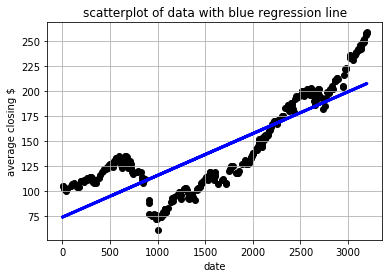

[None]

In [9]:
[plot_each(i) for i in ['spy']]

## Baseline linear regression

In [44]:
def just_accuracy(etf_list):
    '''
    takes a list of etfs and outputs accuracies of 
    Bayesian ridge regression for each etf
    '''
    output = {}
    for etf_name in etf_list:
#         print(etf_name)
        X = np.array([i for i in range(len(data[data['etf']==etf_name].groupby(by='Date').mean().index))]).reshape(-1, 1)
        y = data[data['etf']==etf_name].groupby(by='Date').mean()['Close']
        clf = BayesianRidge(compute_score=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
        clf.fit(X_train, y_train)
        try:
            output[etf_name] = clf.score(X_test, y_test)
        except:
            output[etf_name] = -1
    
    return output

In [45]:
%%time
etf_accuracies = just_accuracy(data['etf'].unique())
df_etf = pd.DataFrame.from_dict(etf_accuracies, orient='index')
df_etf.head(3)

c:\program files\python36\lib\site-packages\sklearn\linear_model\bayes.py:165: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_ = 1. / np.var(y)
c:\program files\python36\lib\site-packages\sklearn\linear_model\bayes.py:197: RuntimeWarning: divide by zero encountered in true_divide
  U / (eigen_vals_ + lambda_ / alpha_)[None, :], U.T))
c:\program files\python36\lib\site-packages\sklearn\linear_model\bayes.py:201: RuntimeWarning: invalid value encountered in multiply
  logdet_sigma_[:n_samples] += alpha_ * eigen_vals_
c:\program files\python36\lib\site-packages\sklearn\linear_model\bayes.py:211: RuntimeWarning: invalid value encountered in multiply
  gamma_ = (np.sum((alpha_ * eigen_vals_) /
c:\program files\python36\lib\site-packages\sklearn\linear_model\bayes.py:212: RuntimeWarning: invalid value encountered in multiply
  (lambda_ + alpha_ * eigen_vals_)))


Wall time: 15min 37s


In [46]:
df_etf.head()

,0
aadr,0.856253
aaxj,0.548266
acim,0.816800
actx,0.137994
acwf,0.723872


In [47]:
df_etf[0].describe()

count    1342.000000
mean        0.542708
std         0.330544
min        -2.187973
25%         0.286447
50%         0.634162
75%         0.816768
max         0.985279
Name: 0, dtype: float64

## Lag plots, Seasonal plots, and Autocorrelation plots

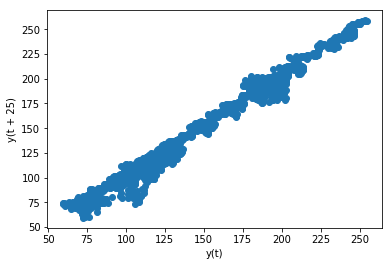

In [13]:
lag_plot(data[data['etf']=='spy']['Close'],lag=25)

<Figure size 432x288 with 0 Axes>

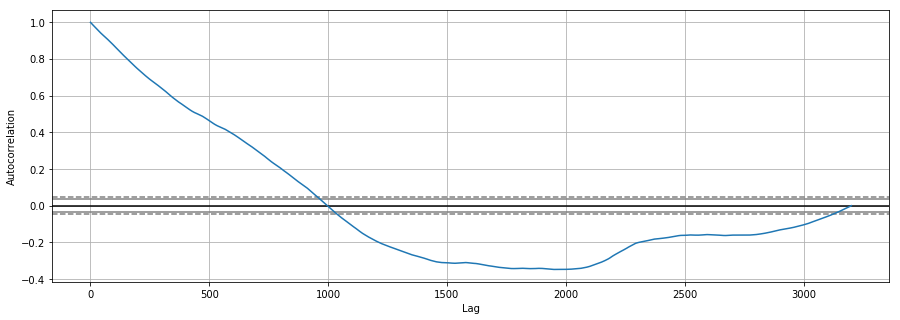

In [14]:
plt.clf()
fig, ax = plt.subplots(figsize=(15, 5))
autocorrelation_plot(data[data['etf']=='spy']['Close'], ax=ax)

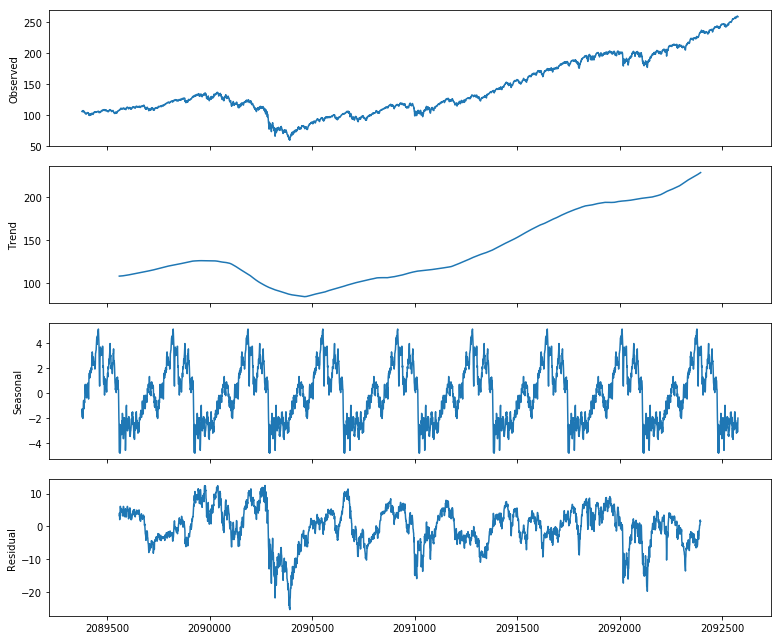

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
import statsmodels.api as sm
seasonal_decomposition = sm.tsa.seasonal_decompose(data[data["etf"]=='spy']["Close"],freq=365) # The frequncy is annual
figure = seasonal_decomposition.plot()
plt.show()

## calculate autocorrelation

In [16]:
def autocorrelation_measures_730(variable='Close'):
    '''
    calculate autocorrelations for variable on 7, and 30 day lags
    '''
    lag_7 = []
    lag_30 = []
    for each_etf in data['etf'].unique():
        lag7_val = data[data['etf']== each_etf][variable].autocorr(lag=7)        
        if np.isnan(lag7_val):
            pass
        else: lag_7.append(lag7_val)
        lag30_val = data[data['etf']== each_etf][variable].autocorr(lag=30)
        if np.isnan(lag30_val):
            pass
        else: lag_30.append(lag30_val)
    return lag_7, lag_30

In [17]:
lag7, lag30 = autocorrelation_measures_730()
# print(lag7)
# print(lag30)

c:\program files\python36\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\program files\python36\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [18]:
stats.mean(lag7)

0.9743308975955385

In [19]:
stats.mean(lag30)

0.9191575954860506

In [50]:
def autocorrelation_measures(variable='Close'):
    '''
    calculate autocorrelations for variable on 
    each ETFs AND for 1-30 day lags
    
    returns a dictionary: 
        KEY = ETF_name
        VALUE = {lag_time: autocorrelation_value}
    '''
    lag_dicts = {}
    for each_etf in data['etf'].unique():
        for lag_time in range(1,31):
            lag_val = data[data['etf']== each_etf][variable].autocorr(lag=lag_time)        
            if np.isnan(lag_val):
                pass
            else: 
                lag_dicts[each_etf] = {lag_time: lag_val}
    return lag_dicts

In [51]:
def read_dict_text(filename):
    '''
    reads the txt files created from autocorrelation_measures()
    and reads the output as a dictionary
    '''
    with open(filename, 'r', encoding='utf-8') as fh:
        autocorr_lags_1 = ast.literal_eval(fh.read())
    return autocorr_lags_1

In [52]:
def ac_dif_lag():
    '''
    combines the autocorrelation_measures() dictionaries together
    '''
    autocorrelation_dif_lags = {}
    for i in range(1,9):
        temp = read_dict_text('output{}.txt'.format(i))
        autocorrelation_dif_lags.update(temp)
    return autocorrelation_dif_lags

In [53]:
dif_lags = ac_dif_lag()

# Predictions

In [48]:
X = np.array([i for i in range(len(data[data['etf']==etf_name].groupby(by='Date').mean().index))]).reshape(-1, 1)
y = data[data['etf']==etf_name].groupby(by='Date').mean()['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
clf2 = MLPRegressor(hidden_layer_sizes=(100, ), activation = 'tanh', max_iter = 1000)        
clf.fit(self.X_train, self.y_train)
clf.predict(self.X_test)
self.acc = clf.score(self.X_test, self.y_test)

In [49]:
P = predictors(data, 'spy')
P.pipeline_predictor()

TypeError: must be real number, not str